# 0. Installing embedding prerequisites

If you use x86 machines or ARM (Mac M1/M2/...) chips with python 3.8, then you may benefit from `spacy` embedding.

In [1]:
!pip install --upgrade spacy
!python -m spacy download en_core_web_md


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 15.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


Check that is works:

In [21]:
import spacy
nlp = spacy.load('en_core_web_md')

import numpy as np

def embed(text: str):
    return nlp(line['Question']).vector

## 0.a. ARM case 

Probably by the day of your lab the issue is not fixed. Then use `fasttext` of whatever.

In [ ]:
!pip install fasttext

In [ ]:
import fasttext, fasttext.util
fasttext.util.download_model('en', if_exists='ignore')

In [5]:
ft = fasttext.load_model('cc.en.300.bin')

def embed(text: str):
    return ft.get_sentence_vector(text)

# 00. Index data structure

And now let us install the NMSlib. To avoid M1 crashes please do not use prebuilt wheels.

In [8]:
!pip uninstall nmslib -y
!pip install nmslib --no-binary :all:

  Using cached nmslib-2.1.1.tar.gz (188 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... \^C
anceled
ERROR: Operation cancelled by user


Check it works:

In [5]:
import nmslib

# Generate some vectors 

Download [Jeopardy dataset](https://github.com/hsu-ai-course/hsu.ai/blob/master/code/datasets/nlp/JEOPARDY_CSV.zip). Unpack it! Read it as CSV. Embed `Question`s with spacy model.

In [9]:
MAX = 30000
DATASET_FILENAME = '../datasets/JEOPARDY_CSV.csv'

In [11]:
import csv
import numpy as np

strings = []

with open(DATASET_FILENAME, 'r', encoding='utf8') as f:
    dr = csv.DictReader(f, delimiter=',')
    for i, line in enumerate(dr):
        if i == MAX: break
        strings.append(line)

print("Strings:", len(strings))

Strings: 30000


In [19]:
import tqdm
import pickle
import os

# if vector dimension is different - please change
vectors = np.zeros((MAX, 300))

if os.path.exists('vectors'):
    print("Vectors are precomputed! Loading ...", end='')
    with open('vectors', 'rb') as f:
        vectors = pickle.load(f)
    print(" done")
else:
    print("Vectors are not precomputed. Computing ...", end='')
    for i, line in enumerate(tqdm.tqdm(strings)):


        # TODO your code here to find `Question` embedding and write it to i'th string of the matrix        
        vectors[i, :] = ...



    print(" dumping ...", end='')
    with open('vectors', 'wb') as f:
        pickle.dump(vectors, f)
    print(" done")

Vectors are not precomputed. Computing ...

  0%|          | 6/30000 [00:13<19:17:02,  2.31s/it]


KeyboardInterrupt: 

In [9]:
print("Vectors:", vectors.shape, "| strings:", len(strings))

Vectors: (30000, 300) | strings: 30000


# 1. Index construction

- index methods: `'nsw'`, `'hnsw'` and [others](https://github.com/nmslib/nmslib/blob/master/manual/methods.md). We will use `hnsw` and `brute_force`.
- space: `'cosinesimil'` and [many others](https://github.com/nmslib/nmslib/blob/master/manual/spaces.md). We will use `cosinesimil`.
- `post` parameters of `createIndex()`: optimization after HNSW built. [Read more here](https://github.com/nmslib/nmslib/blob/master/manual/methods.md#graph-based-search-methods-sw-graph-and-hnsw).
- `ef`: the size of the dynamic list for the nearest neighbors (used during the search). `efConstruction` improves the quality of a constructed graph and leads to higher accuracy of search, also leads to longer indexing times. Typically `ef=100..2000`. Similarly, increasing the value of `efSearch` improves recall at the expense of longer retrieval time.
- `M`: defines the maximum number of neighbors. The reasonable range of values for these parameters is `5..100`.

Here implement `find_for_vector` and `find_for_batch` methods according to the quick start documentation.

In [10]:
import nmslib

def get_index(
        vectors,
        method='hnsw',
        space='cosinesimil',
        postprocessing_optimization_level=2,
        efConstruction=100,
        efSearch=100,
        M=16,
        cutoff=None
):
    import gc
    gc.collect()

    if cutoff is not None:
        vectors = vectors[:cutoff]

    index = nmslib.init(method=method, space=space, space_params = {
        "efConstruction": efConstruction,
        "efSearch": efSearch,
        "M": M,
    })
    index.addDataPointBatch(vectors)
    if method == 'hnsw':
        # this parameter appies to HNSW only
        index.createIndex({'post': postprocessing_optimization_level}, print_progress=True)
    else:
        index.createIndex(print_progress=True)
    return index


# should return the list of ids, sorted by dist from closest
def find_for_vector(index, vector, nn) -> list:
    # TODO your code here
    ...


# should return list of lists of indices. Outer list is len(batch), inner lists are `nn`
def find_for_batch(index, batch, nn) -> list:
    # TODO your code here
    ...

## Construct buckets with ground truth

In [11]:
bucket = ['opera', 'math', 'geography', 'films', 'cats', 'zebra',
          'cooking', 'armory', 'war', 'history', 'money', 'books',
          'quantum physics', 'snakes', 'sea', 'plants', 'chemistry',
          'stars', 'science fiction', 'languages', 'clothes']
bucket_vectors = [embed(t) for t in bucket]
bucket += [s['Question'] for s in strings[150:14000:7]]
bucket_vectors += [v for v in vectors[150:14000:7]]
print(len(bucket))

2000


## Let's collect ACCURATE nearest neighbours with flat index (no index)

In [12]:
# dataset sizes
DS = [2000, 5000, 10000, 20000, 30000]
# M values
MS = [8, 16, 32, 64]
# ef values
EFS = [100, 200, 400]

In [13]:
flats = {}
for cutoff in DS:
    flats[cutoff] = get_index(vectors, method='brute_force', cutoff=cutoff)

In [14]:
ground_truth = {}
for cutoff in DS:
    bucket_results = find_for_batch(flats[cutoff], bucket_vectors, nn=1000)
    ground_truth[cutoff] = bucket_results

## Compute recall @N

Implement recall@N computation. Discuss the values.

In [15]:
def recall(sorted_result : list, sorted_ground_truth: list, N: int) -> float:
    # your code here
    ...

In [16]:
for b in ground_truth[10000][:5]:
    print(recall(b, b, 700), recall(b[:500], b, 700), recall(b[:350], b, 700), recall([], b, 700))

1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0


Discuss the values.
- Why do you see these numbers? 
- Why are they equal?

# 2. Test HNSW

Create an index with default settings and assess its recall numbers.

In [ ]:
hnsw = get_index(vectors, method='hnsw')

In [18]:
vector_id = 5
vector = bucket_vectors[vector_id]
reference = ground_truth[DS[-1]][vector_id]

for n in [100, 1000, 2000]:
    ids = find_for_vector(hnsw, bucket_vectors[5], nn=n)
    print(f"recall@{n} =", recall(ids, ground_truth[DS[-1]][5], n))

recall@100 = 0.5
recall@1000 = 0.191
recall@2000 = 0.0955


Discuss: why recall drops with the growth of N?

# 3. Assessment

Let's vary parameters of index to see how it influences the following properties:
- construction time.
- search time (for a bucket in total).
- `recall@100`, `recall@1000`, and `recall@100` for 1000 results.

What do we vary? Dataset size `D`, `M`, and `ef`.

In [19]:
import time

def test(index, bucket_vectors, nn=100):
    start = time.time()
    result = find_for_batch(index, bucket_vectors, nn=nn)
    return time.time() - start, result

In [ ]:
from itertools import product
import tqdm
import time

# full combination of parameters for grid search
hypers = list(product(MS, DS, EFS))
result = []

for M, D, ef in tqdm.tqdm(hypers):
    start = time.time()

    # todo write here the code to construct index object given provided hyperparameters
    I = get_index( ... )


    build_time = time.time() - start

    t100, ids100 = test(I, bucket_vectors, nn=100)
    t1000, ids1000 = test(I, bucket_vectors, nn=1000)
    r100, r1000, r100_ = 0., 0., 0.

    for i, r in enumerate(ground_truth[D]):
        r100 += recall(ids100[i], r, 100)
        r1000 += recall(ids1000[i], r, 1000)
        r100_ += recall(ids1000[i], r, 100)

    r100 /= len(bucket_results)
    r1000 /= len(bucket_results)
    r100_ /= len(bucket_results)

    result.append(
        [M, D, ef, build_time, t100, t1000, r100, r1000, r100_]
    )

In [23]:
import pandas as pd
headers = ["M", "D", "ef", "build time", "search time 100",
           "search time 1000", "recall@100", "recall@1000", "recall@100*"]
# d = {}
# for i, h in enumerate(headers):
#     d[headers[i]] = [r[i] for r in result]
d = {'M': [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64],
     'D': [2000, 2000, 2000, 5000, 5000, 5000, 10000, 10000, 10000, 20000, 20000, 20000, 30000, 30000, 30000, 2000, 2000, 2000, 5000, 5000, 5000, 10000, 10000, 10000, 20000, 20000, 20000, 30000, 30000, 30000, 2000, 2000, 2000, 5000, 5000, 5000, 10000, 10000, 10000, 20000, 20000, 20000, 30000, 30000, 30000, 2000, 2000, 2000, 5000, 5000, 5000, 10000, 10000, 10000, 20000, 20000, 20000, 30000, 30000, 30000], 'ef': [100, 200, 400, 100, 200, 400, 100, 200, 400, 100, 200, 400, 100, 200, 400, 100, 200, 400, 100, 200, 400, 100, 200, 400, 100, 200, 400, 100, 200, 400, 100, 200, 400, 100, 200, 400, 100, 200, 400, 100, 200, 400, 100, 200, 400, 100, 200, 400, 100, 200, 400, 100, 200, 400, 100, 200, 400, 100, 200, 400],
     'build time': [1.2023499011993408, 1.7564306259155273, 1.2401323318481445, 3.036581039428711, 3.120455741882324, 5.00188422203064, 9.21626353263855, 8.831474304199219, 10.22080683708191, 26.930122137069702, 28.125447511672974, 27.45817232131958, 45.473998069763184, 46.203126192092896, 45.8721764087677, 1.1187622547149658, 1.0918090343475342, 1.091902732849121, 5.042696714401245, 3.2557640075683594, 3.1318938732147217, 10.23164439201355, 9.963123321533203, 10.43823504447937, 23.775625467300415, 25.328428983688354, 22.725796222686768, 45.47703695297241, 44.44892883300781, 43.945903301239014, 1.4958360195159912, 1.0915729999542236, 1.097449779510498, 3.1630699634552, 4.947232007980347, 3.150470018386841, 10.085084199905396, 8.873437881469727, 8.289905071258545, 24.273258209228516, 25.48603653907776, 25.35785412788391, 43.50138187408447, 45.01574349403381, 45.0508873462677, 1.112732172012329, 1.1275148391723633, 1.8677048683166504, 3.153505802154541, 3.1399619579315186, 4.737122535705566, 8.451914072036743, 9.857214450836182, 10.148664474487305, 24.703448057174683, 25.191707372665405, 24.21133041381836, 43.23887038230896, 43.16575884819031, 45.50611114501953], 'search time 100': [0.13348031044006348, 0.2267301082611084, 0.13672113418579102, 0.18017578125, 0.1735072135925293, 0.20840835571289062, 0.3713693618774414, 0.2605869770050049, 0.2635660171508789, 0.3556818962097168, 0.33999061584472656, 0.5037844181060791, 0.36380815505981445, 0.3677389621734619, 0.37248897552490234, 0.18381094932556152, 0.20595812797546387, 0.1551346778869629, 0.16846895217895508, 0.1994619369506836, 0.20127344131469727, 0.23146629333496094, 0.25821805000305176, 0.21472787857055664, 0.5156335830688477, 0.4848661422729492, 0.33612990379333496, 0.36309051513671875, 0.3635692596435547, 0.5853819847106934, 0.1886911392211914, 0.13483905792236328, 0.1316826343536377, 0.17061638832092285, 0.21447443962097168, 0.1788640022277832, 0.23378682136535645, 0.48386168479919434, 0.2380383014678955, 0.2912251949310303, 0.3136780261993408, 0.3541231155395508, 0.388594388961792, 0.36530160903930664, 0.3899245262145996, 0.16048049926757812, 0.14029979705810547, 0.2399158477783203, 0.16714191436767578, 0.17015624046325684, 0.30962681770324707, 0.2373344898223877, 0.25632381439208984, 0.25405359268188477, 0.31022119522094727, 0.312488317489624, 0.5417599678039551, 0.3719973564147949, 0.3691375255584717, 0.5706653594970703], 'search time 1000': [0.22066760063171387, 0.41185641288757324, 0.21856188774108887, 0.2941858768463135, 0.33592653274536133, 0.32727551460266113, 0.6686599254608154, 0.4308583736419678, 0.4286210536956787, 0.5604681968688965, 0.5798652172088623, 0.7847754955291748, 0.6035068035125732, 0.6324596405029297, 0.5737583637237549, 0.22559523582458496, 0.2314131259918213, 0.24630069732666016, 0.31146907806396484, 0.34294915199279785, 0.3537168502807617, 0.37843775749206543, 0.44083309173583984, 0.39939260482788086, 0.749204158782959, 0.8031167984008789, 0.8193032741546631, 0.6047735214233398, 0.5871396064758301, 0.9357039928436279, 0.2175447940826416, 0.2884371280670166, 0.2503237724304199, 0.30808115005493164, 0.3409848213195801, 0.29386019706726074, 0.40557336807250977, 0.7880551815032959, 0.41585302352905273, 0.48641443252563477, 0.5078887939453125, 0.5440020561218262, 0.616614580154419, 0.6347513198852539, 0.5792169570922852, 0.22800898551940918, 0.3592355251312256, 0.3914065361022949, 0.30497169494628906, 0.3173255920410156, 0.3682572841644287, 0.39995861053466797, 0.4393270015716553, 0.4319343566894531, 0.5222659111022949, 0.5266668796539307, 0.5950372219085693, 0.5844604969024658, 0.5894145965576172, 0.6103055477142334], 'recall@100': [0.8963450000000126, 0.897440000000012, 0.8972850000000122, 0.861685000000003, 0.8619650000000033, 0.8621150000000031, 0.8312499999999963, 0.8313849999999958, 0.8322549999999966, 0.8049449999999974, 0.8055099999999963, 0.8060699999999975, 0.784079999999999, 0.7837449999999986, 0.7848749999999979, 0.8978800000000132, 0.8982350000000134, 0.8979450000000134, 0.8617600000000027, 0.8615200000000032, 0.8625700000000018, 0.8312249999999952, 0.8310949999999957, 0.8315949999999962, 0.8062199999999975, 0.8048999999999971, 0.804989999999997, 0.7837699999999992, 0.7845299999999992, 0.7832399999999989, 0.896490000000013, 0.8966850000000127, 0.8967450000000137, 0.8621150000000024, 0.8617650000000026, 0.862165000000002, 0.8315249999999951, 0.8321049999999958, 0.8319649999999972, 0.805804999999998, 0.8057099999999968, 0.8053099999999979, 0.7836349999999987, 0.7852249999999984, 0.7838649999999978, 0.8963650000000124, 0.8973000000000142, 0.8971850000000132, 0.8622700000000021, 0.8621150000000027, 0.8618450000000034, 0.8314799999999964, 0.8318549999999951, 0.8324149999999954, 0.8044049999999968, 0.8051499999999961, 0.8058649999999966, 0.7839049999999984, 0.7840499999999999, 0.7841799999999978], 'recall@1000': [0.2995090000000003, 0.3025105000000003, 0.3009265000000003, 0.31995850000000076, 0.32088650000000096, 0.3225349999999998, 0.31970300000000096, 0.317970000000001, 0.3201885000000018, 0.31266750000000015, 0.3130305000000001, 0.31460450000000084, 0.30750950000000055, 0.3076140000000003, 0.30824600000000024, 0.29813749999999917, 0.299898, 0.2960524999999992, 0.3194234999999994, 0.3214255000000006, 0.32190950000000007, 0.3192595000000002, 0.3196030000000004, 0.3196905000000006, 0.3138004999999999, 0.3136115000000007, 0.31212900000000027, 0.30858, 0.30772000000000066, 0.30747350000000095, 0.29680249999999975, 0.3034355000000005, 0.3005730000000004, 0.32248650000000023, 0.3222775000000005, 0.3223659999999998, 0.31910800000000017, 0.3192675000000009, 0.3197005000000013, 0.3135295000000001, 0.31234049999999913, 0.3122210000000002, 0.30812250000000035, 0.3080799999999997, 0.3077920000000007, 0.3007520000000006, 0.2939580000000007, 0.2970160000000002, 0.32094950000000033, 0.32295450000000064, 0.32195750000000073, 0.31957949999999985, 0.31859499999999996, 0.31930749999999997, 0.3119619999999998, 0.31407800000000036, 0.3132839999999999, 0.3074520000000004, 0.30825800000000014, 0.30817350000000016], 'recall@100*': [0.8963450000000126, 0.897440000000012, 0.8972850000000122, 0.861685000000003, 0.8619650000000033, 0.8621150000000031, 0.8312499999999963, 0.8313849999999958, 0.8322549999999966, 0.8049449999999974, 0.8055099999999963, 0.8060699999999975, 0.784079999999999, 0.7837449999999986, 0.7848749999999979, 0.8978800000000132, 0.8982350000000134, 0.8979450000000134, 0.8617600000000027, 0.8615200000000032, 0.8625700000000018, 0.8312249999999952, 0.8310949999999957, 0.8315949999999962, 0.8062199999999975, 0.8048999999999971, 0.804989999999997, 0.7837699999999992, 0.7845299999999992, 0.7832399999999989, 0.896490000000013, 0.8966850000000127, 0.8967450000000137, 0.8621150000000024, 0.8617650000000026, 0.862165000000002, 0.8315249999999951, 0.8321049999999958, 0.8319649999999972, 0.805804999999998, 0.8057099999999968, 0.8053099999999979, 0.7836349999999987, 0.7852249999999984, 0.7838649999999978, 0.8963650000000124, 0.8973000000000142, 0.8971850000000132, 0.8622700000000021, 0.8621150000000027, 0.8618450000000034, 0.8314799999999964, 0.8318549999999951, 0.8324149999999954, 0.8044049999999968, 0.8051499999999961, 0.8058649999999966, 0.7839049999999984, 0.7840499999999999, 0.7841799999999978]}
df = pd.DataFrame(d)
# df.to_pickle('results.pkl')
df

,M,D,ef,build time,search time 100,search time 1000,recall@100,recall@1000,recall@100*
0,8,2000,100,1.202350,0.133480,0.220668,0.896345,0.299509,0.896345
1,8,2000,200,1.756431,0.226730,0.411856,0.897440,0.302511,0.897440
2,8,2000,400,1.240132,0.136721,0.218562,0.897285,0.300927,0.897285
3,8,5000,100,3.036581,0.180176,0.294186,0.861685,0.319959,0.861685
4,8,5000,200,3.120456,0.173507,0.335927,0.861965,0.320887,0.861965
5,8,5000,400,5.001884,0.208408,0.327276,0.862115,0.322535,0.862115
6,8,10000,100,9.216264,0.371369,0.668660,0.831250,0.319703,0.831250
7,8,10000,200,8.831474,0.260587,0.430858,0.831385,0.317970,0.831385
8,8,10000,400,10.220807,0.263566,0.428621,0.832255,0.320189,0.832255
9,8,20000,100,26.930122,0.355682,0.560468,0.804945,0.312668,0.804945


Discuss, how parameters (using the table) affect perfromance?

### * Load results (if needed)

(NB: for some reason `pyplot` does not survive together with `nmslib` in Windows. So you may save we save and load).

In [24]:
import pandas as pd
headers = ["M", "D", "ef", "build time", "search time 100", "search time 1000", "recall@100", "recall@1000", "recall@100*"]
DS = [2000, 5000, 10000, 20000, 30000]
# M values
MS = [8, 16, 32, 64]
# ef values
EFS = [100, 200, 400]
# df = pd.read_pickle('results.pkl')

## Displaying results

Let us display them now!

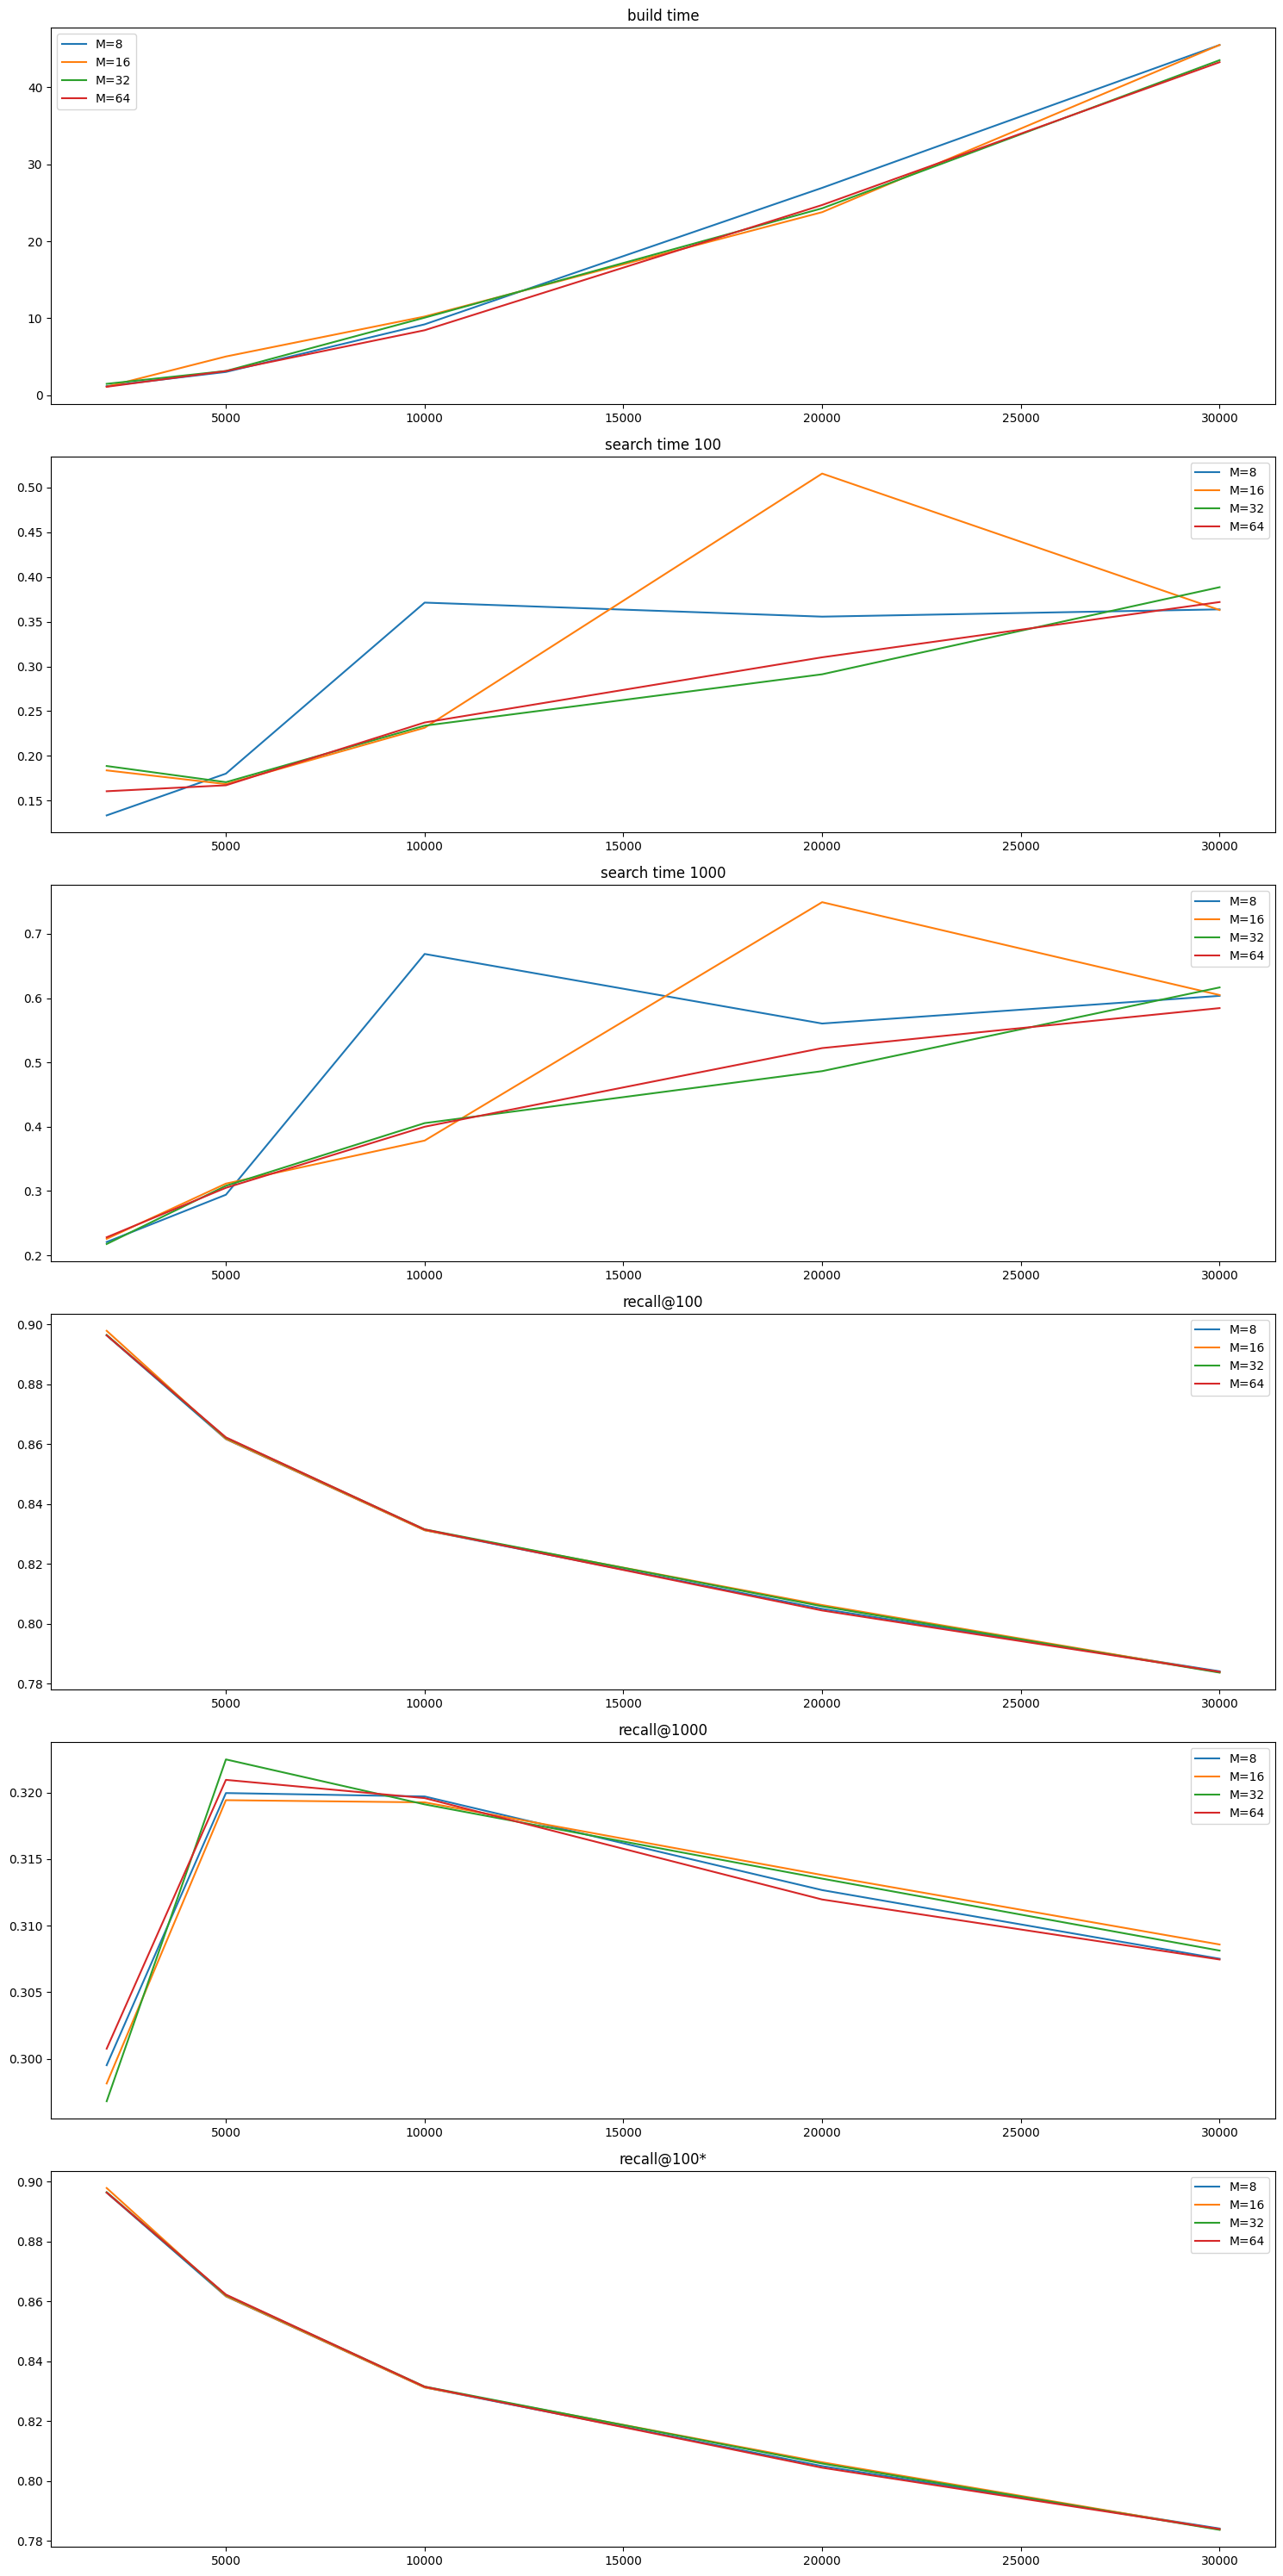

In [25]:
%matplotlib inline 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(headers) - 3, figsize=(15, 30))

for j in range(len(MS)):
    for k in range(3, len(headers)):
        # print(MS[j], k)
        subdata = df[(df['M'] == MS[j]) & (df['ef'] == EFS[0])]
        ax[k-3].plot(subdata['D'], subdata[headers[k]], label=f"M={MS[j]}")
        ax[k-3].set_title(f"{headers[k]}")
        ax[k-3].legend()

plt.tight_layout()
plt.show()